In [43]:
import pandas as pd
from plotnine import *

filename = 'overhead.csv'
data = pd.read_csv(filename)

data['Total Time (s)'] = data['Init'] + data['Setting'] + data['Compute']
data = data.drop('IO', axis=1)
data['OceanColumns'] = 5 * data['NumRuns']
data

,Version,NumRuns,Init,Setting,Compute,Total Time (s),OceanColumns
0,Fortran,1,0.068100,0.000000,0.000900,0.069000,5
1,Chapel,1,0.067213,0.002007,0.001106,0.070326,5
2,Fortran,5,0.239700,0.000100,0.004100,0.243900,25
3,Chapel,5,0.245564,0.009482,0.004869,0.259915,25
4,Fortran,10,0.457200,0.000100,0.008200,0.465500,50
5,Chapel,10,0.466601,0.017571,0.009659,0.493831,50
6,Fortran,50,2.202500,0.000800,0.043700,2.247000,250
7,Chapel,50,2.226380,0.091301,0.047800,2.365481,250
8,Fortran,100,4.466300,0.001500,0.083300,4.551100,500
9,Chapel,100,4.491040,0.177615,0.096862,4.765517,500


In [44]:
chapel = data[data['Version'] == 'Chapel'].set_index('NumRuns')
fortran = data[data['Version'] == 'Fortran'].set_index('NumRuns')

overheads = ((chapel['Total Time (s)'] - fortran['Total Time (s)']) / fortran['Total Time (s)']) * 100
overheads

NumRuns
1      1.921739
5      6.566216
10     6.086144
50     5.272853
100    4.711323
Name: Total Time (s), dtype: float64

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 5 rows containing missing values.


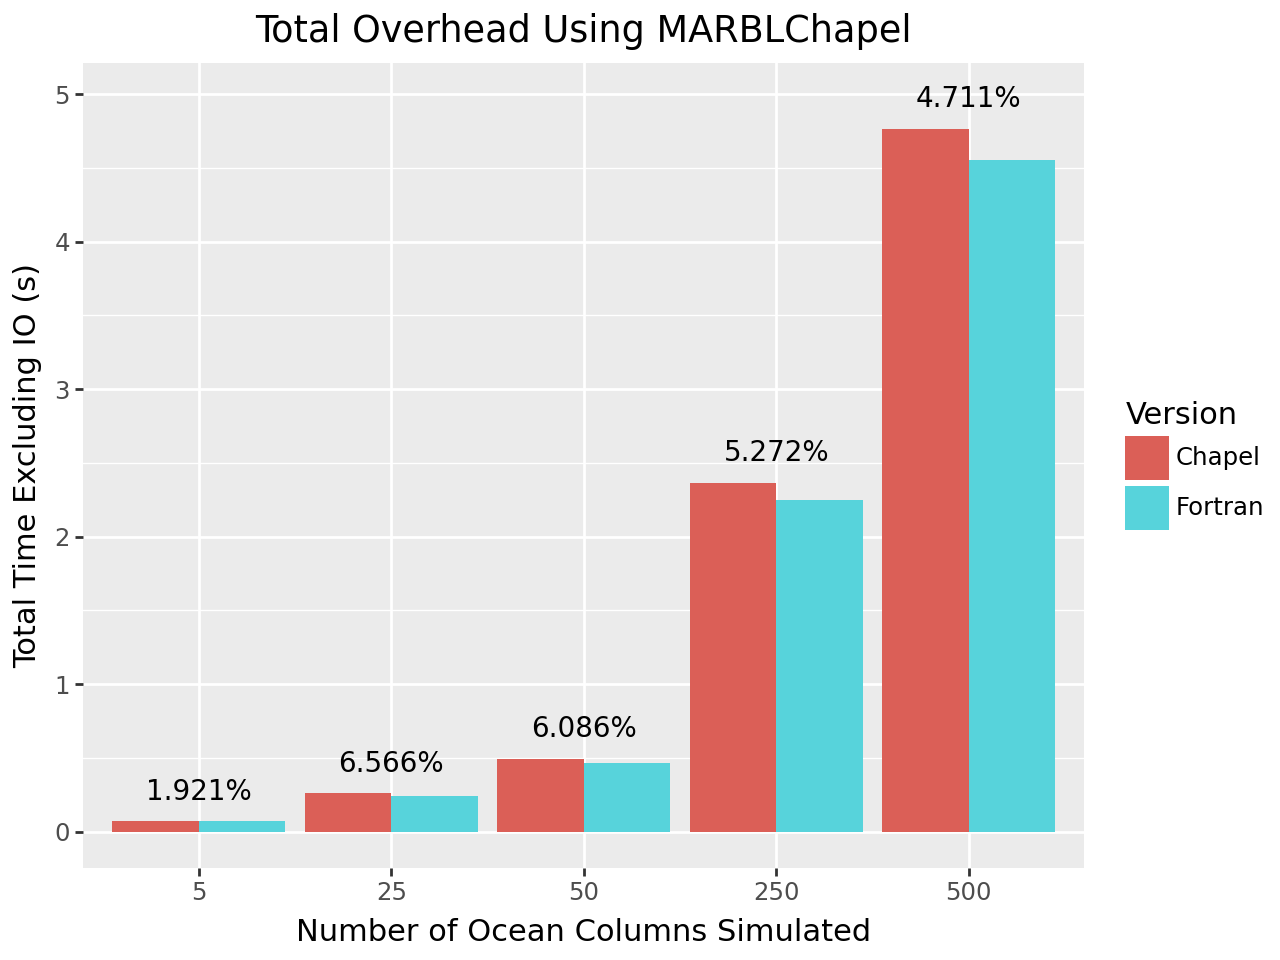

In [45]:
# Overall performance comparison
overhead_df = pd.DataFrame({'NumRuns':overheads.index, 'Label': overheads.values})
overhead_df

merged = data.merge(overhead_df)
merged

merged['Label'] = merged['Label'].astype(str).str[0:5] + "%"
merged['Label'] = merged.apply(lambda row : row['Label'] if row['Version'] == 'Chapel' else None, axis=1)
p = ggplot(merged, aes(x='factor(OceanColumns)', y='Total Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') + geom_text(aes(label='Label'), nudge_y=0.2, size=10)
p = p + labs (x='Number of Ocean Columns Simulated', y='Total Time Excluding IO (s)',title='Total Overhead Using MARBLChapel')
p

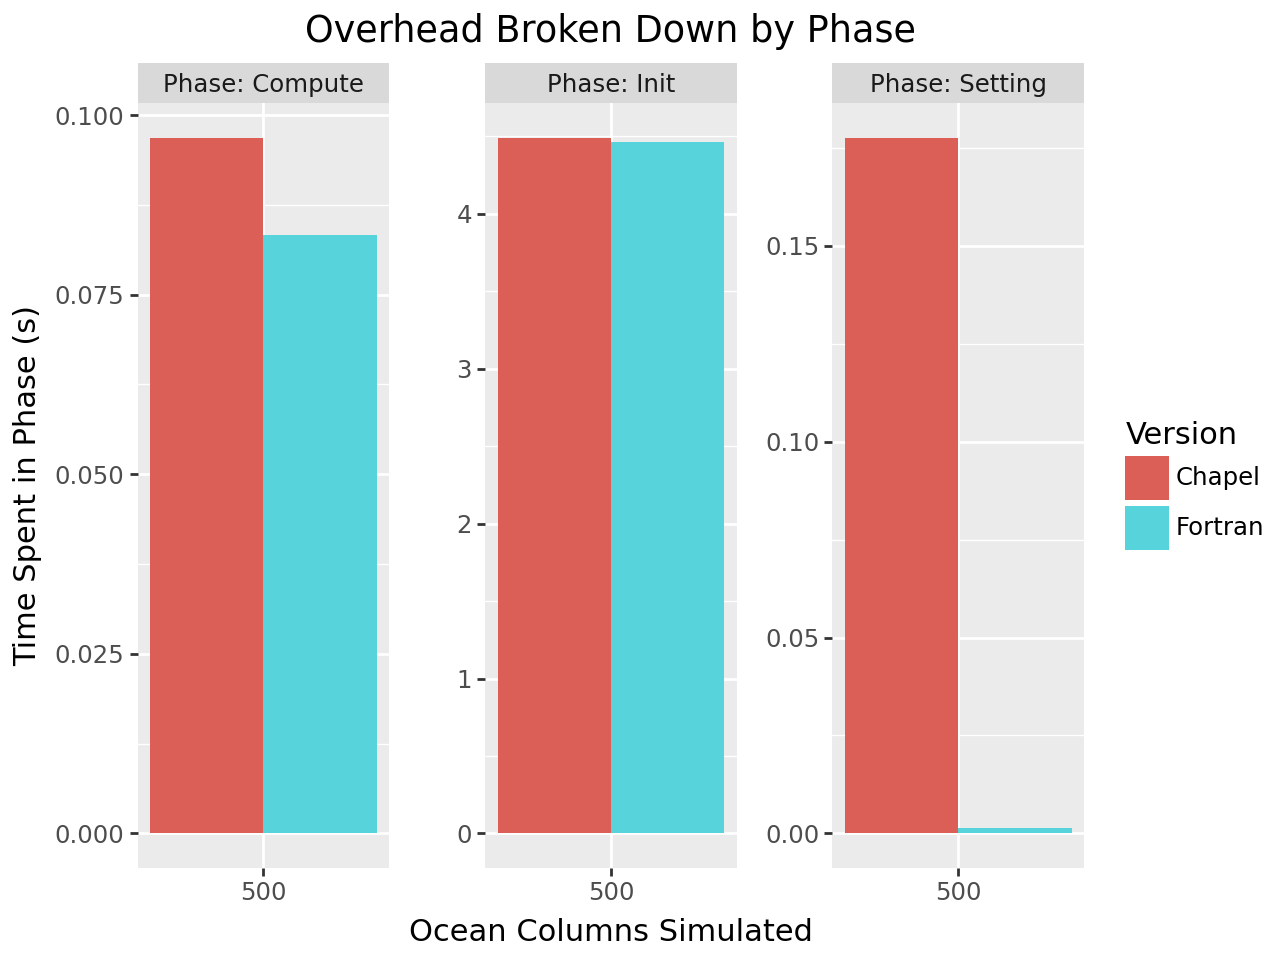

In [46]:
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=['Init', 'Setting', 'Compute'],  # replace with your actual 4 column names
    var_name='Phase',
    value_name='Time'
)
melted
melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Phase', scales='free',labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase')
p

In [47]:
# Now need to make the scaling plots
weak_data = pd.read_csv('weak-scaling.csv')
strong_data = pd.read_csv('strong-scaling.csv')

strong_data['TotalColumns'] = strong_data['NodeCount'] * strong_data['RunsPerNode'] * 5

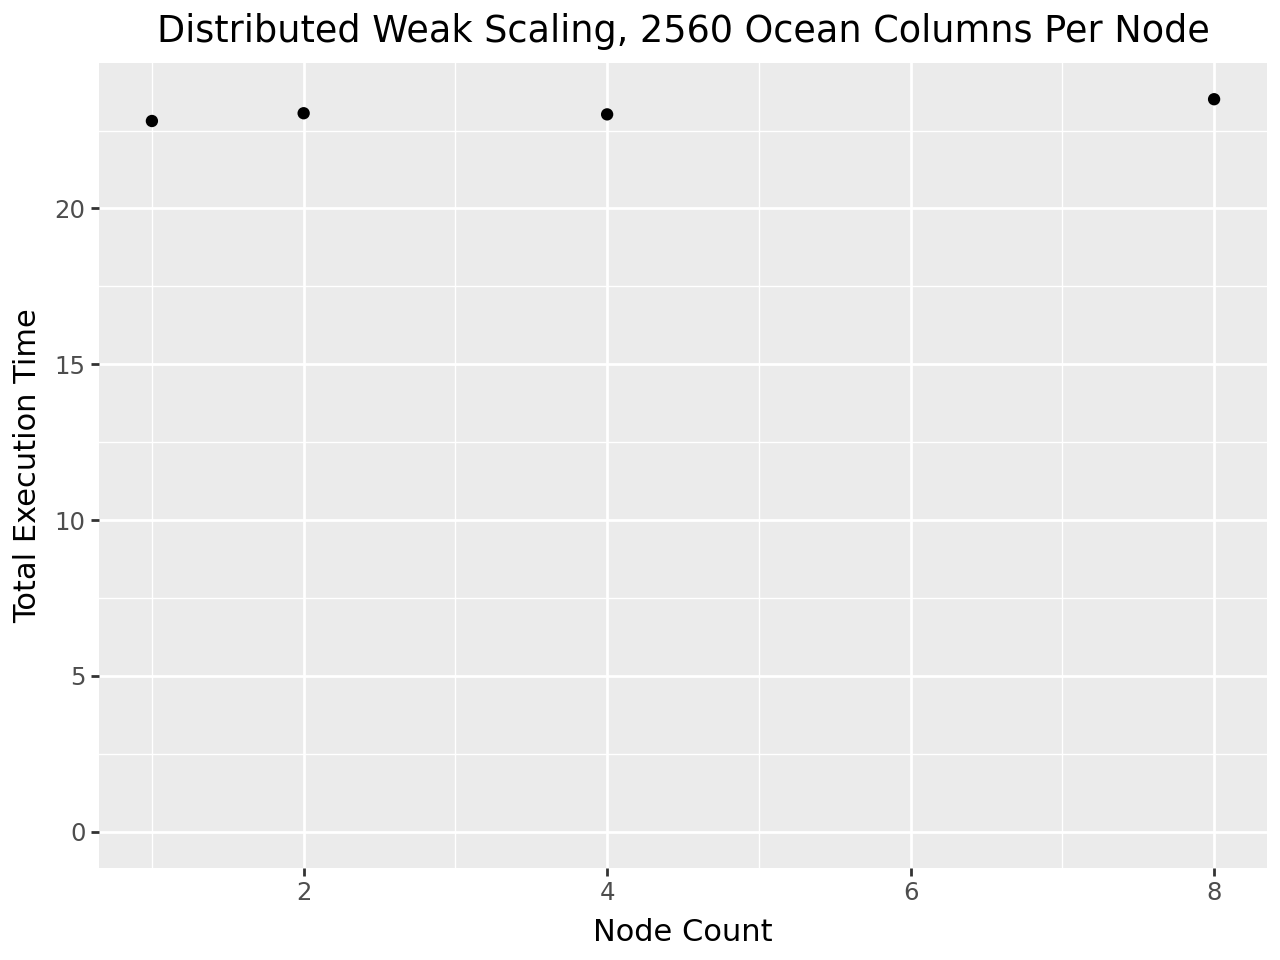

In [48]:
# Weak scaling plot
p = ggplot(weak_data, aes(x='NodeCount', y='Time')) + geom_point()
p = p + labs(x="Node Count", y='Total Execution Time', title="Distributed Weak Scaling, 2560 Ocean Columns Per Node")
p = p + scale_y_continuous(limits=(0,None))
p

   NodeCount  Series  Total Execution Time
0          1   Ideal              22.68960
1          2   Ideal              11.34480
2          4   Ideal               5.67240
3          8   Ideal               2.83620
4          1  Actual              22.68960
5          2  Actual              11.57410
6          4  Actual               5.87384
7          8  Actual               3.01428


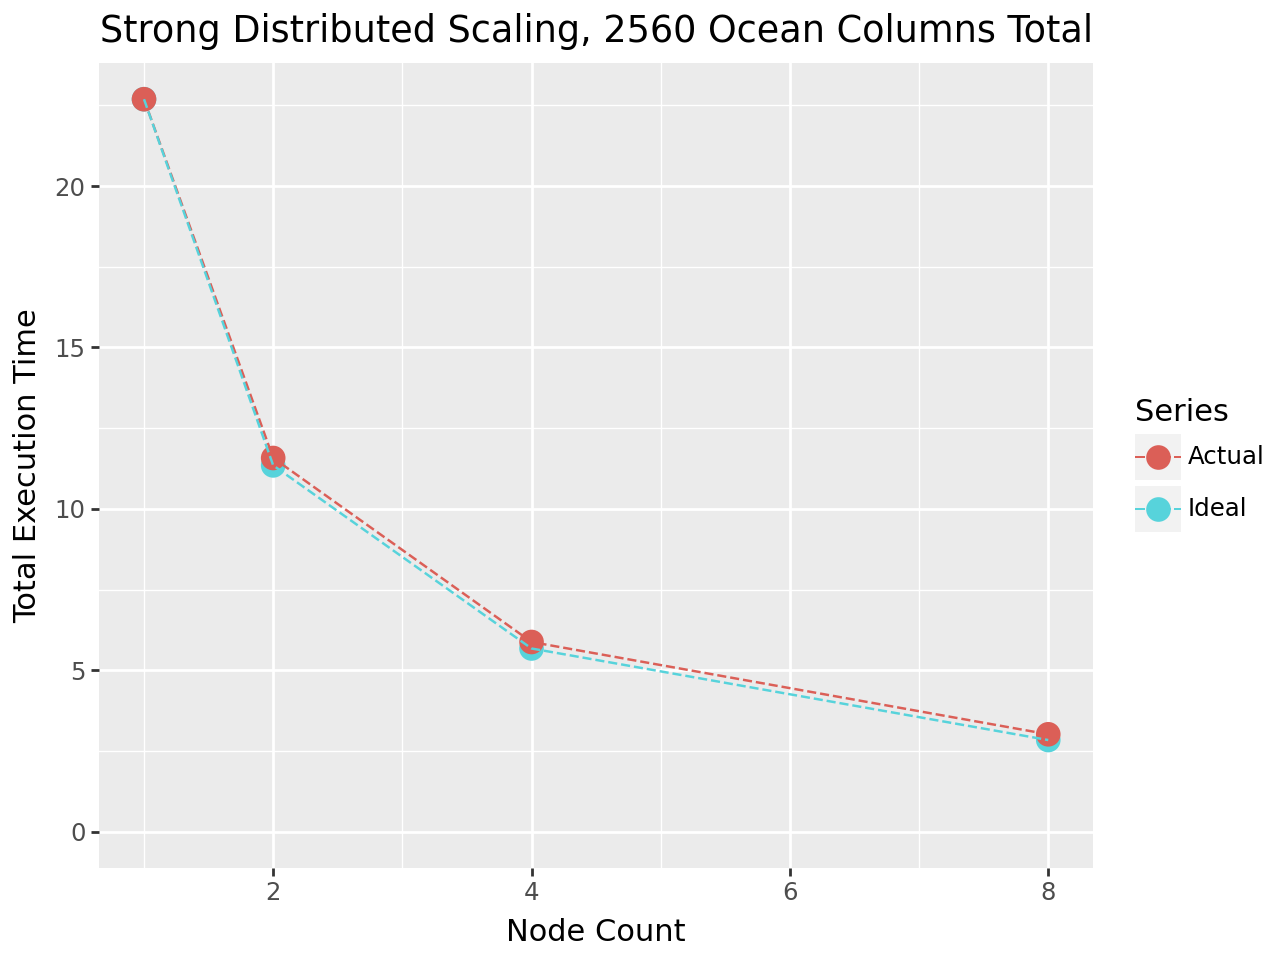

In [59]:
# Strong Scaling plots

one_node_time = strong_data[strong_data['NodeCount'] == 1]['Time'].values[0]

strong_data['Ideal'] = one_node_time / strong_data['NodeCount']

melted = pd.melt(strong_data, id_vars=['NodeCount'], value_vars=['Ideal', 'Time'], var_name='Series', value_name='Total Execution Time')
melted['Series'] = melted['Series'].str.replace('Time', 'Actual')

print(melted)
p = ggplot(melted, aes(x='NodeCount', y='Total Execution Time', color='Series')) + geom_point(size=4)
p = p + geom_line(linetype='dashed')
p = p + labs(x='Node Count', y='Total Execution Time', title='Strong Distributed Scaling, 2560 Ocean Columns Total')
p = p + scale_y_continuous(limits=(0,None))
p